## P16. Creating a Kaggle Workflow

In this mission, we're going to explore a workflow to make competing in the Kaggle Titanic competition easier, using a pipeline of functions to reduce the number of dimensions you need to focus on.


In [121]:
import pandas as pd

train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [122]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

def apply_allfx(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    cols = ['Age_categories', 'Fare_categories', 'Title', 'Cabin_type', 'Sex']
    for c in cols:
        df = create_dummies(df, c)
    return df

In [123]:
train = apply_allfx(train)
holdout = apply_allfx(holdout)

## Exploring the Data

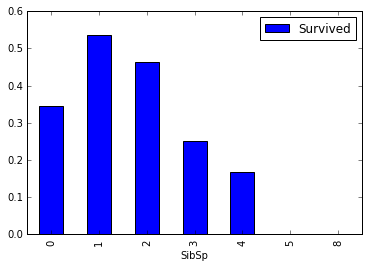

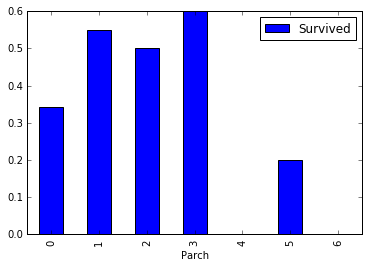

In [124]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

pivot_t = train.pivot_table(index='SibSp', values='Survived')
pivot_t.plot.bar()


pivot_t = train.pivot_table(index='Parch', values='Survived')
pivot_t.plot.bar()




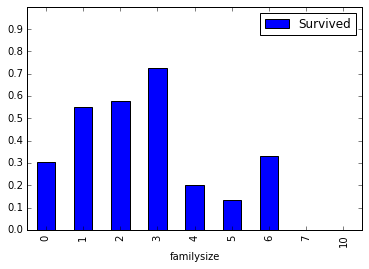

In [125]:
explore_cols = ["SibSp","Parch","Survived"]
explore = train[explore_cols].copy()

explore['familysize'] = explore[["SibSp","Parch"]].sum(axis=1)
pivot = explore.pivot_table(index='familysize',values="Survived")
pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))
plt.show()

Only 30% of the passengers who had no family members onboard survived.

In [126]:
def isalone(df):
    df['familysize'] = df[["SibSp","Parch"]].sum(axis=1)
    df['isalone'] = df['familysize'].apply(lambda x: 1 if x==0 else 0)
    return df

train = isalone(train)
holdout = isalone(holdout)


## Selecting the Best-Performing Features

In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

def select_features(df):
    df_c = df.copy()
    df_c = df_c.select_dtypes(include=[np.number])
    df_c = df_c.dropna()
    
    all_y = df_c['Survived']
    all_X = df_c.drop(['PassengerId', 'Survived'], axis=1)

    rfc = RandomForestClassifier(random_state=1)
    selector = RFECV(rfc, cv=10)
    selector = selector.fit(all_X, all_y)
    best_estimator = all_X.columns[selector.support_]
    return list(best_estimator)

optimized_columns = select_features(train)
optimized_columns

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


['Pclass',
 'Age',
 'SibSp',
 'Parch',
 'Fare',
 'Age_categories_Missing',
 'Age_categories_Infant',
 'Age_categories_Child',
 'Age_categories_Teenager',
 'Age_categories_Young Adult',
 'Age_categories_Adult',
 'Age_categories_Senior',
 'Fare_categories_0-12',
 'Fare_categories_12-50',
 'Fare_categories_50-100',
 'Fare_categories_100+',
 'Title_Master',
 'Title_Miss',
 'Title_Mr',
 'Title_Mrs',
 'Title_Officer',
 'Title_Royalty',
 'Cabin_type_A',
 'Cabin_type_B',
 'Cabin_type_C',
 'Cabin_type_D',
 'Cabin_type_E',
 'Cabin_type_F',
 'Cabin_type_G',
 'Cabin_type_Unknown',
 'Sex_female',
 'Sex_male',
 'familysize',
 'isalone']

## Selecting and Tuning Different Algorithms

In [142]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

def select_model(df, features):
    all_X = df[features]
    all_y = df['Survived']
    models_dict = [{"name":"LogisticRegression",
                   "estimator": LogisticRegression(),
                   "hyperparameters":
                   {"solver": ["newton-cg", "lbfgs", "liblinear"]}
                   },
                   {"name":"KNeighborsClassifier",
                   "estimator": KNeighborsClassifier(),
                   "hyperparameters":
                   {"n_neighbors": range(1,20,2),
                    "weights": ["distance", "uniform"],
                    "algorithm": ["ball_tree", "kd_tree", "brute"],
                    "p": [1,2]}
                   },
                   {"name":"RandomForestClassifier",
                   "estimator": RandomForestClassifier(),
                   "hyperparameters": 
                   {"n_estimators": [4, 6, 9],
                    "criterion": ["entropy", "gini"],
                    "max_depth": [2, 5, 10],
                    "max_features": ["log2", "sqrt"],
                    "min_samples_leaf": [1, 5, 8],
                    "min_samples_split": [2, 3, 5]}
                    }
                  ]
    
    best_estimator = []
    for m in models_dict:
        grid = GridSearchCV(m['estimator'], param_grid=m['hyperparameters'], cv=10)
        grid.fit(all_X, all_y)
        print(grid.best_params_)
        print(grid.best_score_)
        print(grid.best_estimator_)
        best_estimator.append(grid.best_estimator_)
    return best_estimator

best_models = select_model(train, optimized_columns)

{'solver': 'newton-cg'}
0.8181818181818182
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)
{'n_neighbors': 3, 'algorithm': 'kd_tree', 'p': 1, 'weights': 'uniform'}
0.7800224466891134
KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=3, p=1,
           weights='uniform')
{'min_samples_split': 5, 'criterion': 'gini', 'n_estimators': 9, 'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1}
0.8428731762065096
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=5, min_weight_fraction_leaf=0.0,
            n_estima

In [143]:
best_models

[LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
           verbose=0, warm_start=False),
 KNeighborsClassifier(algorithm='kd_tree', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=3, p=1,
            weights='uniform'),
 RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
             max_depth=10, max_features='sqrt', max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=5, min_weight_fraction_leaf=0.0,
             n_estimators=9, n_jobs=1, oob_score=False, random_state=None,
             verbose=0, warm_start=False)]

We can see that the best algorithm in the training data set is for RandomForestClassifier,
yielding an accuracy of ~0.835

## Making a Submission to Kaggle

In [140]:
def save_submission_file(trained_model, features, output='my_submission.csv'):
    holdout_predictions = trained_model.predict(holdout[features])
    submission_df = {'PassengerID':holdout['PassengerID'],
                    'Survived':holdout_predictions}
    submission = pd.Dataframe(submission_df)
    return submission.to_csv(output, index=False)

save_submission_file(best_models[2], optimized_c
